# Score propagation: words -> article
Now that we have some benchmarks, we must try some methods that, given an annotated vocabulary, determine if an article is considered objective or not.

In [2]:
#some imports
import pandas as pd
import glob
import os
import json
import numpy as np
import string
from ast import literal_eval
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

#loading the vocabularies
breit_vocab = "./annotated_vocabs/Breitbart-Nicoli-09-04-22:30.json"
nyt_vocab = "./annotated_vocabs/New York Times-Nicoli-09-04-22:30.json"
breit_ham_vocab = "./annotated_vocabs/Breitbart-Hamilton-09-06-19:21.json"
nyt_ham_vocab = "./annotated_vocabs/New York Times-Hamilton-09-06-19:21.json"
basic_vocab = "./lexicon_3/lexicon_refined.csv"
#breitbart - nicoli and hamilton
with open(breit_vocab, 'r') as f:
    breit_words = json.loads(f.read())
with open(breit_ham_vocab, 'r') as f:
    breit_ham_words = json.loads(f.read())
#nyt - nicoli and hamilton
with open(nyt_vocab, 'r') as f:
    nyt_words = json.loads(f.read())
with open(nyt_ham_vocab, 'r') as f:
    nyt_ham_words = json.loads(f.read())
#non-propagated vocabulary
with open(basic_vocab, 'r') as f:
    basic_words = pd.read_csv(f, index_col = 0)["Valence"].to_dict()

#loading the benchmarked articles
breit_art = (pd.read_csv("../benchmarks/Breitbart.csv", index_col=0)
               .drop(["Unnamed: 0.1", "Unnamed: 0.1.1"], axis = 1))
nyt_art = (pd.read_csv("../benchmarks/NY_times.csv", index_col = 0)
             .drop(["Unnamed: 0.1", "Unnamed: 0.1.1"], axis = 1))
breit_art["Paragraphs"] = breit_art["Paragraphs"].apply(literal_eval)
nyt_art["Paragraphs"] = nyt_art["Paragraphs"].apply(literal_eval)

FileNotFoundError: [Errno 2] No such file or directory: './annotated_vocabs/Breitbart-Nicoli-09-04-22:30.json'

# Util functions

In [40]:
######
#util function
def clean_good(text):
    """
        removes punctuation and symbols and upper cases from text
    """
    def simple_preproc(text):
      return text.translate(str.maketrans('', '', string.punctuation))

    return ( 
            simple_preproc(text).lower()
                                .replace("-", "")
                                .replace('"', '')
                                .replace('“', '')
                                .replace('”', '')
                                .replace("'s", '')
                                .replace("’s", '')
                                .replace("—", '')
                                .replace("  ", " ")
           ) 

######
#util function
def subj_word(word, voc, subj_score = 1, obj_score = -1):
    """
        Given a word and a vocabulary, returns true if 
        the word is subjective, return false if objective or non-present
    """
    try:
        voc[word]
    except KeyError:
        return False
    if voc[word] == subj_score:
        return True
    if voc[word] == obj_score:
        return False

## Method brute-count
Count how many subjective words there are in each article, divide for number of total words.

The lexicon used has been augmented and refined with Nicoli's tecnhique

In [41]:
######    
#method
def brute_count(article_pars, voc):
    """
        article_pars is a list of paragraphs
        voc is the annotated vocabulary
        returns: subj_rate -> normalized rate of subjective words
    """
    subj_rate = 0
    art_length = 0
    for paragraph in article_pars:
        par_clean = clean_good(paragraph)
        par_words = par_clean.split(' ')
        art_length += len(par_words)
        for word in par_words:
            if subj_word(word, voc):
                subj_rate += 1
    return subj_rate/art_length

#just a proxy.. nothing to see here
def brute_count_nyt(article_pars):
    return brute_count(article_pars, nyt_words)
def brute_count_breit(article_pars):
    return brute_count(article_pars, breit_words)

In [42]:
# we apply the brute count function to each article in the NYTimes and Breitbart
nyt_art["nicoli_brute_count_1"] = nyt_art["Paragraphs"].apply(brute_count_nyt)
breit_art["nicoli_brute_count_1"] = breit_art["Paragraphs"].apply(brute_count_breit)

# Brute count - no quotes
Very similar to the first, but it remove automatically paragraphs that contain words that indicate a quote.

In [43]:
######    
#method
def brute_count_noq(article_pars, voc):
    """
        article_pars is a list of paragraphs
        voc is the annotated vocabulary
        returns: subj_rate -> normalized rate of subjective words
    """
    subj_rate = 0
    art_length = 0
    quote_words = ["said", "says", "stated", "states", "wrote", 
                   "writes", "claimed", "claims", "reported", "reports", 
                   "tweeted", "affirmed", "affirms", "tells", "told"]
    for paragraph in article_pars:
        par_clean = clean_good(paragraph)
        par_words = par_clean.split(' ')
        art_length += len(par_words)
        
        #we added this check
        if any(item in par_words for item in quote_words):
            continue
            
        for word in par_words:
            if subj_word(word, voc):
                subj_rate += 1
    return subj_rate/art_length

#just a proxy.. nothing to see here
def brute_count_noq_nyt(article_pars):
    return brute_count_noq(article_pars, nyt_words)
def brute_count_noq_breit(article_pars):
    return brute_count_noq(article_pars, breit_words)

In [44]:
# we apply the brute count, no quote function to each article in the NYTimes and Breitbart
nyt_art["nicoli_brute_count_noq"] = nyt_art["Paragraphs"].apply(brute_count_noq_nyt)
breit_art["nicoli_brute_count_noq"] = breit_art["Paragraphs"].apply(brute_count_noq_breit)

# SAME FUNCTIONS, DIFFERENT LEXICON
This time, we will try to use the non propagated lexicon.

In [45]:
def brute_count_basic(article_pars):
    return brute_count(article_pars, basic_words)
def brute_count_basic_noq(article_pars):
    return brute_count_noq(article_pars, basic_words)

#applying just defined functions
nyt_art["basic_brute_count"] = nyt_art["Paragraphs"].apply(brute_count_basic)
breit_art["basic_brute_count"] = breit_art["Paragraphs"].apply(brute_count_basic)
nyt_art["basic_brute_count_noq"] = nyt_art["Paragraphs"].apply(brute_count_basic_noq)
breit_art["basic_brute_count_noq"] = breit_art["Paragraphs"].apply(brute_count_basic_noq)

# ADAPTING TO HAMILTON-PROPAGATED LEXICON
The Hamilton lexicon does not have an integer score for words, (0,1), but a continous scale.
We adapt the brute count function to accomodate this feature.

This time, for each word, the function sums the score and then divides by the number of words.

It is, hence, a score/word mean.

We'll call it **brute_score**.

In [46]:
######
#util function
def subj_score(word, voc):
    """
        Given a word and a vocabulary, returns its subjectivity score
    """
    try:
        score = voc[word]
        return score
    except KeyError:
        return 0

def brute_score(article_pars, voc):
    """
        article_pars is a list of paragraphs
        voc is the annotated vocabulary
        returns: subj_rate -> normalized subj score of words
    """
    subj_rate = 0
    art_length = 0
    for paragraph in article_pars:
        par_clean = clean_good(paragraph)
        par_words = par_clean.split(' ')
        art_length += len(par_words)
        for word in par_words:
            subj_rate += subj_score(word, voc)
    return subj_rate/art_length


def brute_score_noq(article_pars, voc):
    """
        article_pars is a list of paragraphs
        voc is the annotated vocabulary
        returns: subj_rate -> normalized subj score of words
    """
    subj_rate = 0
    art_length = 0
    quote_words = ["said", "says", "stated", "states", "wrote", 
                   "writes", "claimed", "claims", "reported", "reports", 
                   "tweeted", "affirmed", "affirms", "tells", "told"]
    for paragraph in article_pars:
        par_clean = clean_good(paragraph)
        par_words = par_clean.split(' ')
        art_length += len(par_words)
        
        #we added this check
        if any(item in par_words for item in quote_words):
            continue
            
        for word in par_words:
            subj_rate += subj_score(word, voc)
    return subj_rate/art_length

def brute_score_nyt(article_pars):
    return brute_score(article_pars, voc=nyt_ham_words)
def brute_score_noq_nyt(article_pars):
    return brute_score_noq(article_pars, voc=nyt_ham_words)
def brute_score_breit(article_pars):
    return brute_score(article_pars, voc=breit_ham_words)
def brute_score_noq_breit(article_pars):
    return brute_score_noq(article_pars, voc=breit_ham_words)

In [47]:
#applying just defined functions
nyt_art["ham_brute_score"] = nyt_art["Paragraphs"].apply(brute_score_nyt)
breit_art["ham_brute_score"] = breit_art["Paragraphs"].apply(brute_score_breit)
nyt_art["ham_brute_score_noq"] = nyt_art["Paragraphs"].apply(brute_score_noq_nyt)
breit_art["ham_brute_score_noq"] = breit_art["Paragraphs"].apply(brute_score_noq_breit)
nyt_art.to_csv("./scores_nyt.csv")
breit_art.to_csv("./scores_breit.csv")

In [48]:
nyt_art

,Unnamed: 0.1.1.1,Title,Date,Link,Paragraphs,Authors,Newssite,benchmarks,benchmarks_2,nicoli_brute_count_1,nicoli_brute_count_noq,basic_brute_count,basic_brute_count_noq,ham_brute_score,ham_brute_score_noq
0,6276,Sanders Calls for Rivals to Reject Money From ...,2019-07-17T13:30:04+0000,https://www.nytimes.com/2019/07/17/us/politics...,[WASHINGTON — Senator Bernie Sanders of Vermon...,NaN,New York Times,0,1,0.092455,0.037194,0.005313,0.004251,0.322998,0.172128
1,10256,5 Things to Know for Today,2020-08-14,https://www.nytimes.com/aponline/2020/08/14/us...,"[Your daily look at late-breaking news, upcomi...",The Associated Press,New York Times,1,-1,0.074866,0.074866,0.005348,0.005348,0.343914,0.343914
2,10584,Wisconsin Investigators Say Knife Found at Sce...,2020-08-27,https://www.nytimes.com/reuters/2020/08/27/us/...,"[KENOSHA, Wis. — Investigators of a shooting b...",Reuters,New York Times,0,0,0.040795,0.027197,0.003138,0.002092,0.354560,0.170283
3,11925,Then There Were 5: Mississippi Group Narrows F...,2020-08-18,https://www.nytimes.com/aponline/2020/08/18/us...,"[JACKSON, Miss. — A group recommending a new M...",The Associated Press,New York Times,0,-1,0.067164,0.039179,0.018657,0.014925,0.326596,0.192985
4,6704,Trump’s Conventional Campaign - The New York T...,2019-06-17T22:51:07+0000,https://www.nytimes.com/2019/06/17/us/politics...,"[Hi. Welcome to On Politics, your guide to the...",NaN,New York Times,1,-1,0.126050,0.086835,0.012138,0.006536,0.342401,0.262126
5,7216,Democrats Want to Beat Scott Walker. But the W...,2018-10-14T17:57:30+0000,https://www.nytimes.com/2018/10/14/us/politics...,"[RACINE, Wis. — This city’s downtown was all b...",NaN,New York Times,1,1,0.080847,0.028534,0.006917,0.002594,0.331200,0.179690
6,10628,Texas Gunman Had History of Violence Years Bef...,2020-08-26,https://www.nytimes.com/aponline/2020/08/26/us...,[SAN ANTONIO — The man who killed more than 20...,The Associated Press,New York Times,0,0,0.066421,0.040590,0.009225,0.007380,0.320701,0.171941
7,13201,California Parents Agree to Plead Guilty in Co...,2020-07-11,https://www.nytimes.com/2020/07/11/us/diane-to...,[A California couple have agreed to plead guil...,Michael Levenson,New York Times,1,0,0.034853,0.022788,0.008043,0.006702,0.328726,0.132744
8,11461,"As Wildfires Rage, Californians Fear the Virus...",2020-08-20,https://www.nytimes.com/2020/08/20/us/ca-wildf...,"[SANTA CRUZ, Calif. — A wildfire was raging ou...",Kellen Browning,New York Times,1,-1,0.071429,0.014137,0.004464,0.000744,0.338250,0.100444
9,9815,"WHAT TO WATCH: Democrats Adapt Roll Call, Keyn...",2020-08-18,https://www.nytimes.com/aponline/2020/08/18/us...,[LAS VEGAS — The pageantry often associated wi...,The Associated Press,New York Times,1,1,0.081921,0.072505,0.016008,0.012241,0.340961,0.279387


<AxesSubplot:xlabel='benchmarks_2', ylabel='ham_brute_score_noq'>

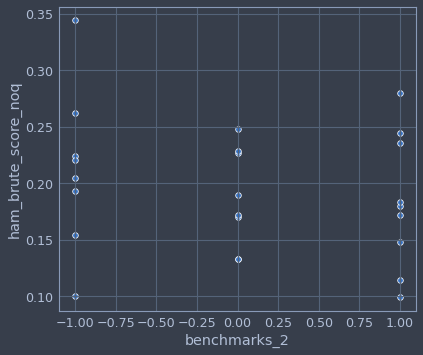

In [57]:
import seaborn as sns
sns.scatterplot(x = "benchmarks_2", 
                y = "ham_brute_score_noq", 
                data = nyt_art)

# Paragraphs wise evaluation

In [76]:
def brute_score_pars(par, voc):
    """
        par is a paragraph
        voc is the annotated vocabulary
        returns: subj_rate -> normalized subj score of words
    """
    subj_rate = 0
    art_length = 0
    par_clean = clean_good(str(par))
    par_words = par_clean.split(' ')
    art_length += len(par_words)
    for word in par_words:
        subj_rate += subj_score(word, voc)
    return subj_rate/art_length

def brute_count_pars(par, voc):
    """
        par is a paragraph
        voc is the annotated vocabulary
        returns: subj_rate -> normalized subj score of words
    """
    subj_rate = 0
    art_length = 0
    par_clean = clean_good(str(par))
    par_words = par_clean.split(' ')
    for word in par_words:
        art_length += len(par_words)
        if subj_word(word, voc):
                subj_rate += 1
    return subj_rate/art_length

def  brute_count_pars_nyt(par):
    return brute_count_pars(par, nyt_words)
def  brute_count_pars_b(par):
    return brute_count_pars(par, breit_words)
def  brute_score_pars_nyt(par):
    return brute_score_pars(par, nyt_ham_words)
def  brute_score_pars_b(par):
    return brute_score_pars(par, breit_ham_words)

#importing benchmarks for paragraphs
pars_df = pd.read_csv("../benchmarks/bench_pars.csv", index_col=0)
pars_nyt_df = pars_df[pars_df["Newssite"] == "nyt"]
pars_breit_df = pars_df[pars_df["Newssite"] == "breitbart"]

In [77]:
pars_nyt_df["nic_brute_count"] = pars_nyt_df["Paragraphs"].apply(brute_count_pars_nyt)
pars_breit_df["nic_brute_cout"] = pars_breit_df["Paragraphs"].apply(brute_count_pars_b)
pars_nyt_df["ham_brute_score"] = pars_nyt_df["Paragraphs"].apply(brute_score_pars_nyt)
pars_breit_df["ham_brute_score"] = pars_breit_df["Paragraphs"].apply(brute_score_pars_b)

/home/willinki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/willinki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/willinki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

<AxesSubplot:xlabel='Score', ylabel='ham_brute_score'>

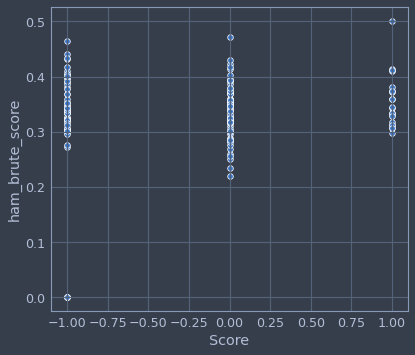

In [78]:
sns.scatterplot(x = "Score", 
                y = "ham_brute_score", 
                data = pars_nyt_df)